# Image compression using auto-encoders with the TensorFlow Keras functional API

We will use 3 models to build the auto-encoders : the encoder, the decoder, and the full auto-encoder. This will make the performance analysis easier.

# Imports :

In [108]:
#install similarity indexes
!pip install image-similarity-measures

#For faster evaluation of the FSIM metric, the pyfftw package is required, install via:
!pip install image-similarity-measures[speedups]
!pip install pyfftw

In [109]:
!pip install tabulate

In [110]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Image Processing Project/psnr_lib')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Lambda, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint, History, ReduceLROnPlateau

from image_similarity_measures import quality_metrics

from psnr_human_vision  import mean_psnr_hvs_m

# Definining parameters :

The loss function give the minimum for ```intermediate_dim = 400```

In [112]:
# Model architecture parameters
latent_dim = 32
intermediate_dim = 400

# Model training parameters
nb_epochs = 30
batch_size = 100

# Loading the MNIST dataset :

In [113]:
# Load MNIST dataset
(x_train, _), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten images
input_shape = (28, 28)
original_dim = input_shape[0] * input_shape[1]
x_train = x_train.reshape((len(x_train), original_dim))
x_test = x_test.reshape((len(x_test), original_dim))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


# Building the encoder :

In [114]:
encoder_input = Input(shape=original_dim, name="encoder_input")

encoder_intermediate = Dense(intermediate_dim, activation='relu', name="encoder_intermediate")(encoder_input)

encoder_output = Dense(latent_dim, activation='relu', name="encoder_output")(encoder_intermediate)

In this example, we use 2 `Dense` layers and 2 `LeakyReLu` activation layers for the encoder. The input data is a 28*28 pixels image which is mapped into a 2 dimensional latent space.

After setting the model up, the next step is to build it using the `Model` function.



In [115]:
encoder = Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder_intermediate (Dens  (None, 400)               314000    
 e)                                                              
                                                                 
 encoder_output (Dense)      (None, 32)                12832     
                                                                 
Total params: 326832 (1.25 MB)
Trainable params: 326832 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The model is not large and the number of units in the `Dense` layer can be increased for better feature detection.

After building the encoder, we will build the decoder.

# Building the decoder :

In [116]:
decoder_input = Input(shape=latent_dim, name="decoder_input")

decoder_intermediate = Dense(intermediate_dim, activation="relu", name="decoder_intermediate")(decoder_input)

decoder_output = Dense(original_dim, activation='sigmoid', name="decoder_output")(decoder_intermediate)

In [117]:
decoder = Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 32)]              0         
                                                                 
 decoder_intermediate (Dens  (None, 400)               13200     
 e)                                                              
                                                                 
 decoder_output (Dense)      (None, 784)               314384    
                                                                 
Total params: 327584 (1.25 MB)
Trainable params: 327584 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Building the autoencoder

In [118]:
ae_input = Input(shape=original_dim, name="ae_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = Model(ae_input, ae_decoder_output, name="ae")
ae.summary()

Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_input (InputLayer)       [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 32)                326832    
                                                                 
 decoder (Functional)        (None, 784)               327584    
                                                                 
Total params: 654416 (2.50 MB)
Trainable params: 654416 (2.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Adding checkpoints before compiling to have the history of loss values during training

In [119]:
checkpoint_filepath = 'autoencoder_checkpoint.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',  # You can change this to 'val_accuracy' if you have accuracy metrics
    mode='min',          # You can change this to 'max' if you have accuracy metrics
    verbose=1
)

history = History()

The training dynamically adjusts the training parameters during model training using the ReduceLROnPlateau callback, which reduces the learning rate when a monitored metric (e.g., validation loss) has stopped improving.

In [120]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # You can change this to 'val_accuracy' if you have accuracy metrics
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

Compile the model using `mse` loss function and `Adam` optimizer.
We could change the loss function to be `loss = tf.keras.metrics.categorical_accuracy()`.
See https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile for the compilation settings.

In [121]:
ae.compile(loss="mse", optimizer=Adam(learning_rate=0.0001))

# Training the model :

Train the model with Checkpoint, History, and ReduceLROnPlateau callbacks


In [122]:
training_history = ae.fit(
    x_train, x_train,
    epochs=nb_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint, history, reduce_lr]
)

Epoch 1/30
594/600 [============================>.] - ETA: 0s - loss: 0.0677
Epoch 1: val_loss improved from inf to 0.03639, saving model to autoencoder_checkpoint.h5
600/600 [==============================] - 5s 6ms/step - loss: 0.0674 - val_loss: 0.0364 - lr: 1.0000e-04
Epoch 2/30
 31/600 [>.............................] - ETA: 1s - loss: 0.0366

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/600 [==============================] - ETA: 0s - loss: 0.0296
Epoch 2: val_loss improved from 0.03639 to 0.02349, saving model to autoencoder_checkpoint.h5
600/600 [==============================] - 3s 4ms/step - loss: 0.0296 - val_loss: 0.0235 - lr: 1.0000e-04
Epoch 3/30
600/600 [==============================] - ETA: 0s - loss: 0.0208
Epoch 3: val_loss improved from 0.02349 to 0.01799, saving model to autoencoder_checkpoint.h5
600/600 [==============================] - 3s 5ms/step - loss: 0.0208 - val_loss: 0.0180 - lr: 1.0000e-04
Epoch 4/30
589/600 [============================>.] - ETA: 0s - loss: 0.0172
Epoch 4: val_loss improved from 0.01799 to 0.01556, saving model to autoencoder_checkpoint.h5
600/600 [==============================] - 3s 5ms/step - loss: 0.0171 - val_loss: 0.0156 - lr: 1.0000e-04
Epoch 5/30
593/600 [============================>.] - ETA: 0s - loss: 0.0152
Epoch 5: val_loss improved from 0.01556 to 0.01403, saving model to autoencoder_checkpoint.h5
600/600 [

Save the model weights


In [123]:
ae.save_weights('autoencoder_weights.h5')

# Plot the training history


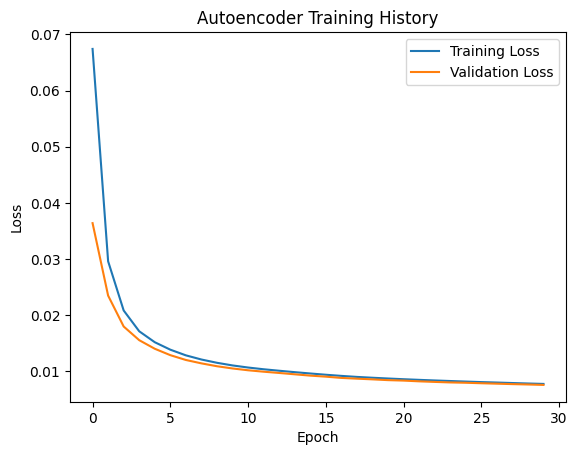

In [124]:
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Load the model weights


In [125]:
ae.load_weights('autoencoder_weights.h5')

# Testing the model :


In [126]:
encoded_images = encoder.predict(x_test)
decoded_images = decoder.predict(encoded_images)

313/313 [==============================] - 1s 1ms/step


# Display a grid of sampled digits :

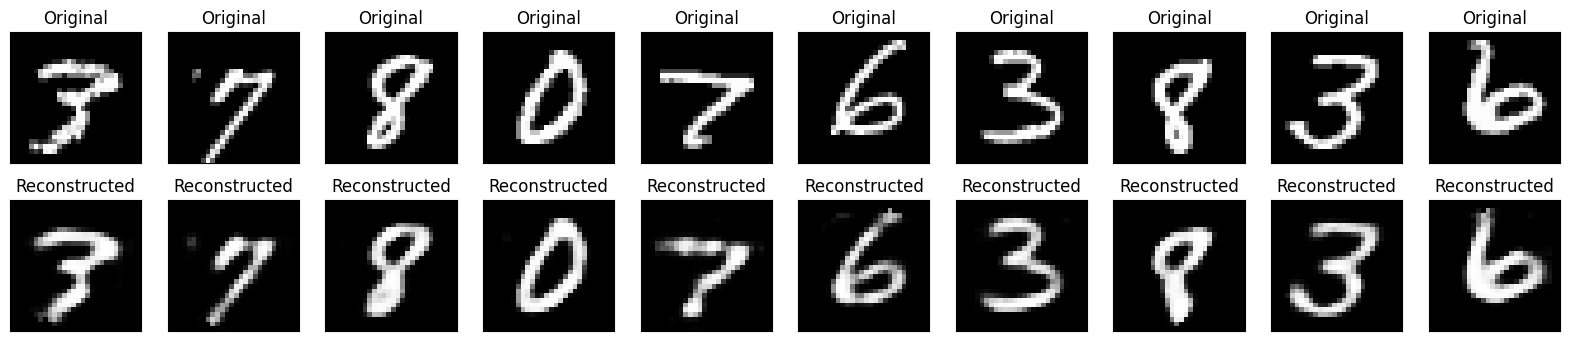

In [127]:
# Visualize Original vs Reconstructed Images
n = 10  # Number of images to display
random_indices = np.random.choice(len(x_test), size=n, replace=False)
plt.figure(figsize=(20, 4))

for i, idx in enumerate(random_indices):
    # Original Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idx].reshape(*input_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')

    # Reconstructed Images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[idx].reshape(*input_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')

plt.show()

# Display how the latent space clusters different digit classes :

Naive plotting of only 2 dimensions of the N dimensional latent space :

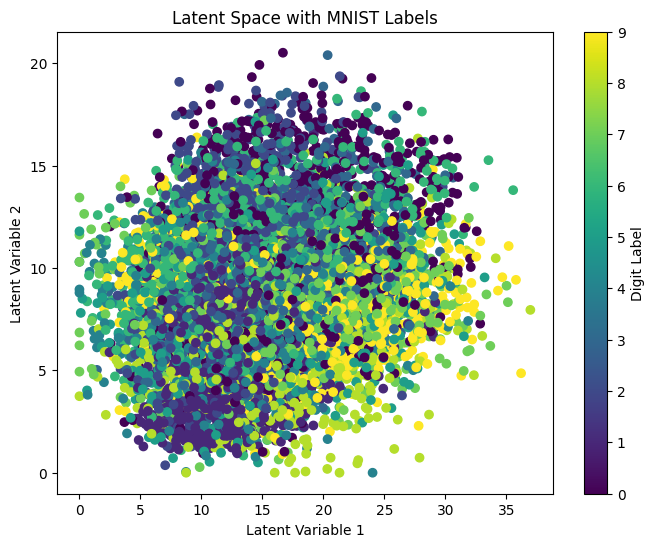

In [128]:
# Plotting the latent space with colors based on MNIST labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=y_test, cmap='viridis')
plt.colorbar(scatter, label='Digit Label')
plt.title('Latent Space with MNIST Labels')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.show()

# Display compression metrics :

In [129]:
x_test = x_test.reshape((len(x_test), 784, 1))
decoded_images = decoded_images.reshape((len(decoded_images), 784, 1))

## Bit Per Pixel (BPP):

In [130]:
bpp = (latent_dim * 32) / original_dim

## Signal-to-Noise Ratio (SNR):

In [131]:
snr = tf.image.psnr(x_test.reshape(-1, *input_shape), decoded_images.reshape(-1, *input_shape), max_val=1.0)
snr = np.mean(snr)

## Peak Signal-to-Noise Ratio (PSNR):

In [132]:
psnr = quality_metrics.psnr(x_test,decoded_images, max_p=255)

## Mean Square Error (MSE):

In [133]:
mse = np.mean((x_test - decoded_images)**2)

## Root Mean Square Error (RMSE):

In [134]:
rmse = quality_metrics.rmse(x_test,decoded_images, max_p=255)

## Peak Signal-to-Noise Ratio Human Vision (PSNR-HVS-M):

In [135]:
# Convert image shape to (28, 28) on all dataset
x_test_hvs = x_test.reshape((10000, 28, 28))
decoded_images_hvs = decoded_images.reshape((10000, 28, 28))

In [136]:
psnr_hvs_m = mean_psnr_hvs_m(x_test_hvs, decoded_images_hvs, 4)

## Structured Similarity Indexing Method (SSIM):

In [137]:
ssim = quality_metrics.ssim(x_test,decoded_images, max_p=255)

## Feature Similarity Indexing Method (FSIM):

In [138]:
fsim = quality_metrics.fsim(x_test,decoded_images)

In [139]:
# Create a list of tuples for the tabulate function
table_data = [
    ("BPP", bpp),
    ("SNR", snr),
    ("PSNR", psnr),
    ("MSE", mse),
    ("RMSE", rmse),
    ("PSNR_HVS_M", psnr_hvs_m),
    ("SSIM", ssim),
    ("FSIM", fsim),
]

# Print the table using tabulate
table = tabulate(table_data, headers=["Metric", "Value"], tablefmt="rst")
print(table)

==========  ============
Metric             Value
==========  ============
BPP          1.30612
SNR         21.1963
PSNR        69.3271
MSE          0.00759221
RMSE         0.000341699
PSNR_HVS_M   0.211659
SSIM         0.999834
FSIM         0.967386
==========  ============
